<a href="https://colab.research.google.com/github/vineet-codes/defi-exploration/blob/main/rewards_staking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

What is the impact of different reward mechanisms for incentivizing users to stake their tokens.

In [265]:
import pandas as pd 
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [266]:
class OneStake() :
    
    def __init__(self, user, startTime, lockPeriod, amount):
      self.user = user
      self.startTime = startTime
      self.lockPeriod = lockPeriod
      self.amount= amount
      self.lastTransferTime = startTime
      assert self.lastTransferTime == self.startTime

    def __repr__(self):
      return f'{self.user}: has staked {self.amount} tokens at {self.startTime} locked for {self.lockPeriod}. Last transfer was {self.lastTransferTime}'

In [428]:
class Stake():

  def __init__(self, rewardStrategy = 0):
    self.stakes = []
    self.users = {}
    self.currentTime = 0;
    self.totalRewards_disbursed = 0
    self.db = pd.DataFrame(columns = ['index', 'user', 'startTime', 'lockPeriod', 'amount', 'currentTime' , 'rewards'])
    self.reward_time_history = []
    self.rewardStrategy = rewardStrategy

  # each stake position will be unique
  def stake(self, user, startTime, lockPeriod, amount, lastTransferTime):
    # assert self.currentTime == startTime
    assert lockPeriod > 0
    assert lastTransferTime >= startTime
    assert amount > 0

    stake_pos = OneStake(user, startTime, lockPeriod, amount)
    self.stakes.append(stake_pos)
    
    index = len(self.stakes) - 1
    
    if len(self.users.get(user, [])) == 0:
      self.users[user] = [index]
    else: 
      self.users[user].append(index)

    # print([index, user, startTime, lockPeriod, amount, self.currentTime, 0])
    
    # add to db
    self.db.loc[len(self.db)] = [index, user, startTime, lockPeriod, amount, self.currentTime, 0]


  def tick(self):
    # tick the timer
    
    # calculate new state and update it
    # process the db to calculate working balance and rewards for currentTime
    for index, row in self.db.iterrows():
      row['currentTime'] = self.currentTime
      if(row['startTime'] + row['lockPeriod'] == row['currentTime']):
        # print(row['user'], row['startTime'], row['lockPeriod'], row['currentTime'])
        # stake complete, calculate reward and update reward given
        # self.reward = self.amount * self.lockPeriod
        if (self.rewardStrategy == 0):
          row['rewards'] = self.reward0(row['amount'], row['lockPeriod'])
        elif (self.rewardStrategy == 1): 
          row['rewards'] = self.reward1(row['amount'], row['lockPeriod'])

        self.totalRewards_disbursed += row['rewards']
    # print(f'Total rewards disbursed at t={self.currentTime} is {self.totalRewards_disbursed}')
    self.reward_time_history.append(self.totalRewards_disbursed)
    self.currentTime += 1

  def move_time(self, by):
    [self.tick() for i in range(by)]

  def reward0(self, amount, lockPeriod):
    # print(amount * lockPeriod)
    return amount * lockPeriod

  def reward1(self, amount, lockPeriod):
    return amount + amount*(lockPeriod/60.)

  def plot_reward_cumulative(self):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,5))
    ax.set_title(f'Cumulative Total YOP distributed: {self.totalRewards_disbursed} at t = {self.currentTime}')
    ax.set_xlabel('time period')
    ax.set_ylabel('YOP distributed quantity')
    ax.plot(self.reward_time_history)

In [429]:
def cohort_stake_activity(stake_yop):
  stake_yop.stake('alice', 1, 6, 300, 1)
  stake_yop.stake('bob', 3, 10, 3000, 3)
  stake_yop.stake('joh', 7, 8, 2000, 7)
  stake_yop.stake('alice', 5, 6, 300, 5)

  stake_yop.move_time(20)
  stake_yop.plot_reward_cumulative()

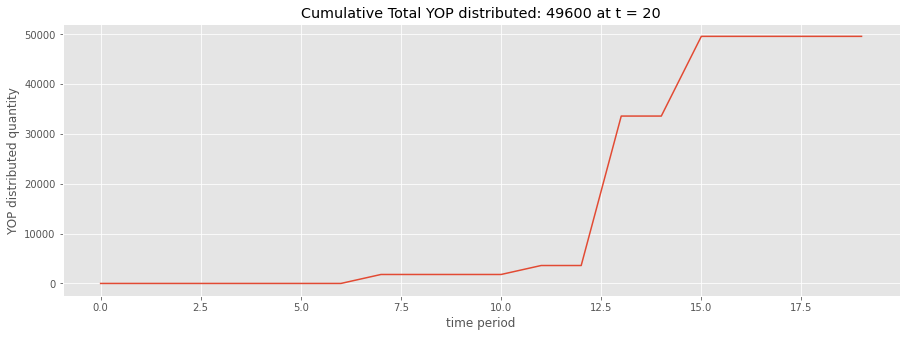

In [430]:
# reward function used amount * lockperiod
stake_yop = Stake(0)
cohort_stake_activity(stake_yop)

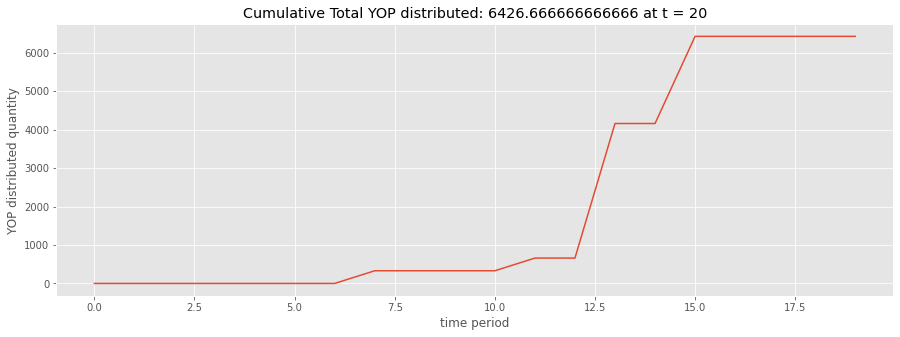

In [431]:
# reward used amount + amount * lockPeriod / 60
stake_yop = Stake(1)
cohort_stake_activity(stake_yop)